# Data_Cleaning, Data_Engineering, Data_Visualizations

## HDDCDD Group

### 1. Load Data & Define Skeleton

**Explanation:** Standard loading. We convert dates and rename columns to be friendly.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# 1. Load the "Skeleton" (The Stock Data)
stock_path = os.path.join(semi_clean_dir, "stock_senti_engineered_imputed_2.csv")
df_skeleton = pd.read_csv(stock_path)
df_skeleton['date'] = pd.to_datetime(df_skeleton['date'])

# Extract unique dates
unique_dates = pd.DataFrame(df_skeleton['date'].unique(), columns=['date']).sort_values('date')

# 2. Load Raw HDD/CDD Data
weather_path = os.path.join(raw_dir, "hddcdd_daily.csv")
df_weather_raw = pd.read_csv(weather_path)
df_weather_raw['date'] = pd.to_datetime(df_weather_raw['date'])

# Rename for consistency
df_weather_raw = df_weather_raw.rename(columns={'hdd_us_pop': 'HDD', 'cdd_us_pop': 'CDD'})

print(f"Skeleton Dates: {len(unique_dates)}")
print(f"Raw Weather Rows: {len(df_weather_raw)}")
df_weather_raw.head()

Skeleton Dates: 3443
Raw Weather Rows: 5884


,date,HDD,CDD
0,2010-01-01,30,0
1,2010-01-02,35,0
2,2010-01-03,38,0
3,2010-01-04,37,0
4,2010-01-05,36,0


### 2. Merge & Impute

**Explanation:** Left Join XLE onto the Skeleton.

**Critical Step:** Weather happens 365 days a year. If your stock skeleton has a Monday, the weather file definitely has that Monday. Missing data should be zero. If any tiny gaps exist, ffill is safe (weather persists)

In [9]:
# 1. Merge (Left Join)
df_weather_clean = pd.merge(unique_dates, df_weather_raw, on='date', how='left')

# 2. Impute (Forward Fill)
df_weather_clean['HDD'] = df_weather_clean['HDD'].ffill()
df_weather_clean['CDD'] = df_weather_clean['CDD'].ffill()

# Fill any remaining NaNs with 0 (safe assumption for degree days if data is missing)
df_weather_clean = df_weather_clean.fillna(0)

print(f"Merged Weather Shape: {df_weather_clean.shape}")

Merged Weather Shape: (3443, 3)


### 3. Feature Engineering (Weather Specific)

**Explanation:** We calculate the Total Demand and the Shock metrics. No Logs, No RSI.

In [12]:
# 1. Total Thermal Demand (The primary load metric)
df_weather_clean['Total_Degree_Days'] = df_weather_clean['HDD'] + df_weather_clean['CDD']

# 2. 7-Day Moving Averages (Smooth out daily noise)
df_weather_clean['HDD_MA7'] = df_weather_clean['HDD'].rolling(window=7).mean()
df_weather_clean['CDD_MA7'] = df_weather_clean['CDD'].rolling(window=7).mean()
df_weather_clean['Total_DD_MA7'] = df_weather_clean['Total_Degree_Days'].rolling(window=7).mean()

# 3. 30-Day Moving Average (The "Seasonal Norm")
df_weather_clean['Total_DD_MA30'] = df_weather_clean['Total_Degree_Days'].rolling(window=30).mean()

# 4. Demand Shock (Deviation from the Monthly Norm)
# Positive = Hotter/Colder than usual (High Demand)
# Negative = Milder than usual (Low Demand)
df_weather_clean['Weather_Shock'] = df_weather_clean['Total_Degree_Days'] - df_weather_clean['Total_DD_MA30']

print("Weather Feature Engineering Complete.")
df_weather_clean.tail()

Weather Feature Engineering Complete.


,date,HDD,CDD,Total_Degree_Days,HDD_MA7,CDD_MA7,Total_DD_MA7,Total_DD_MA30,Weather_Shock
3438,2023-12-21,22,0,22,22.571429,0.0,22.571429,20.166667,1.833333
3439,2023-12-22,21,0,21,22.142857,0.0,22.142857,20.433333,0.566667
3440,2023-12-26,19,0,19,21.571429,0.0,21.571429,20.566667,-1.566667
3441,2023-12-27,20,0,20,21.571429,0.0,21.571429,20.700000,-0.700000
3442,2023-12-28,21,0,21,21.714286,0.0,21.714286,20.900000,0.100000


### 4. Save HDD/CDD Dataset

**Explanation:** Saving as HDDCDD_engineered_7.csv.

In [15]:
output_path = os.path.join(semi_clean_dir, "HDDCDD_engineered_7.csv")
df_weather_clean.to_csv(output_path, index=False)
print(f"Saved processed Weather data to: {output_path}")

Saved processed Weather data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\HDDCDD_engineered_7.csv


### 5. Overlay Visualization (Stock vs. Weather Demand)

**Explanation:** 7 Graphs.

- **Right Axis (Teal):** Total_DD_MA7. It will look like a "Sine Wave" (High in Winter, Dip in Spring, High in Summer, Dip in Fall).

- **Insight:** Look for the Winter Storm Uri (Feb 2021). You should see a massive spike in the Teal line. Did the Gas Stocks (EOG, XOM) react?

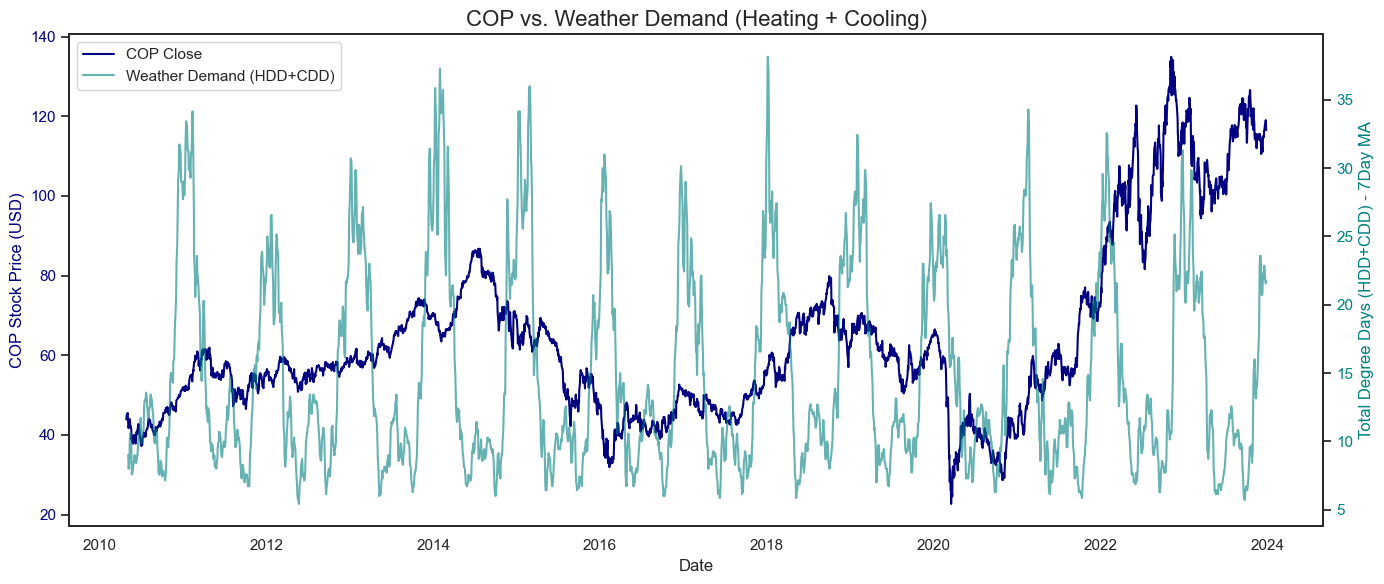

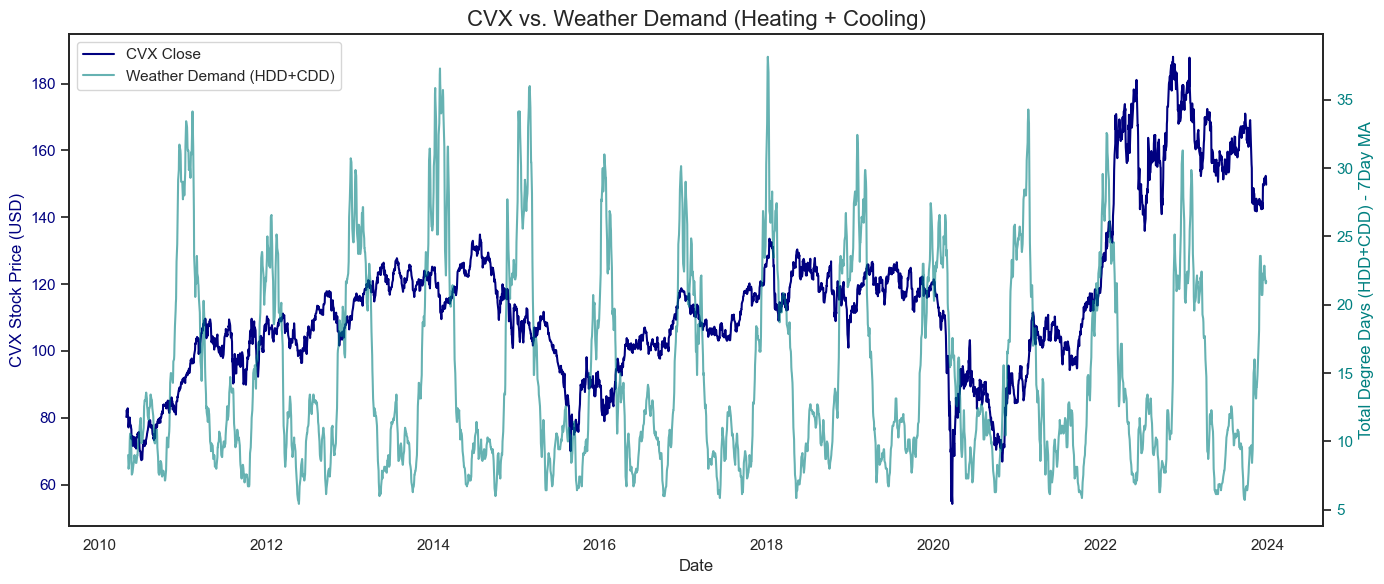

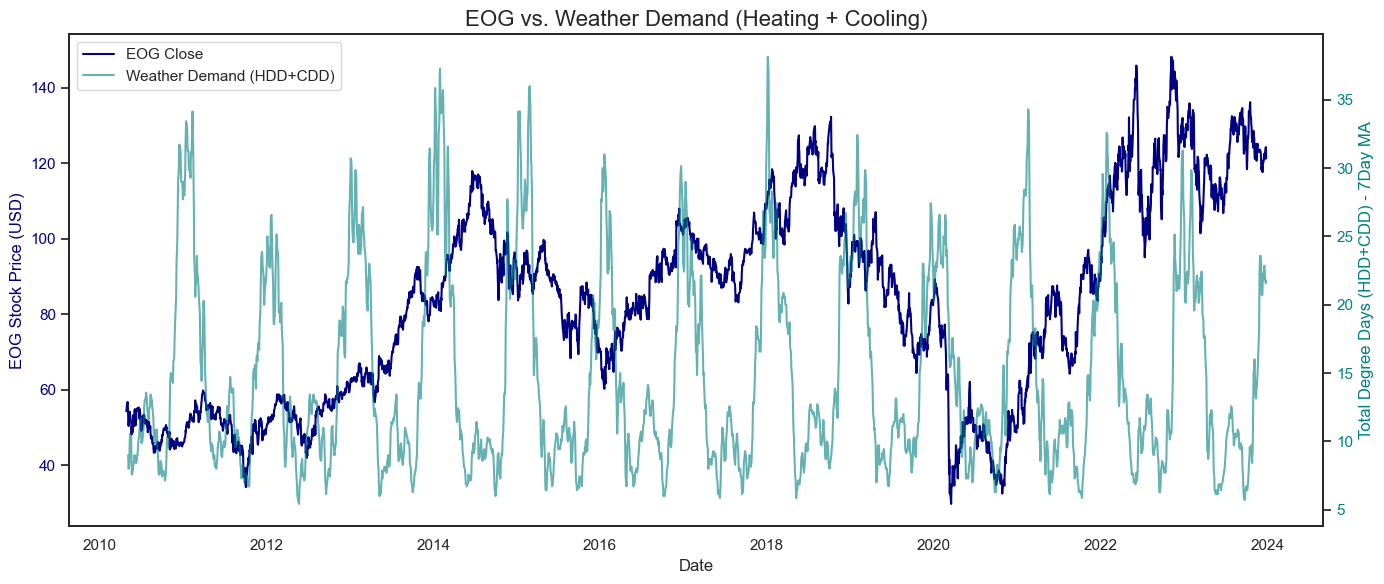

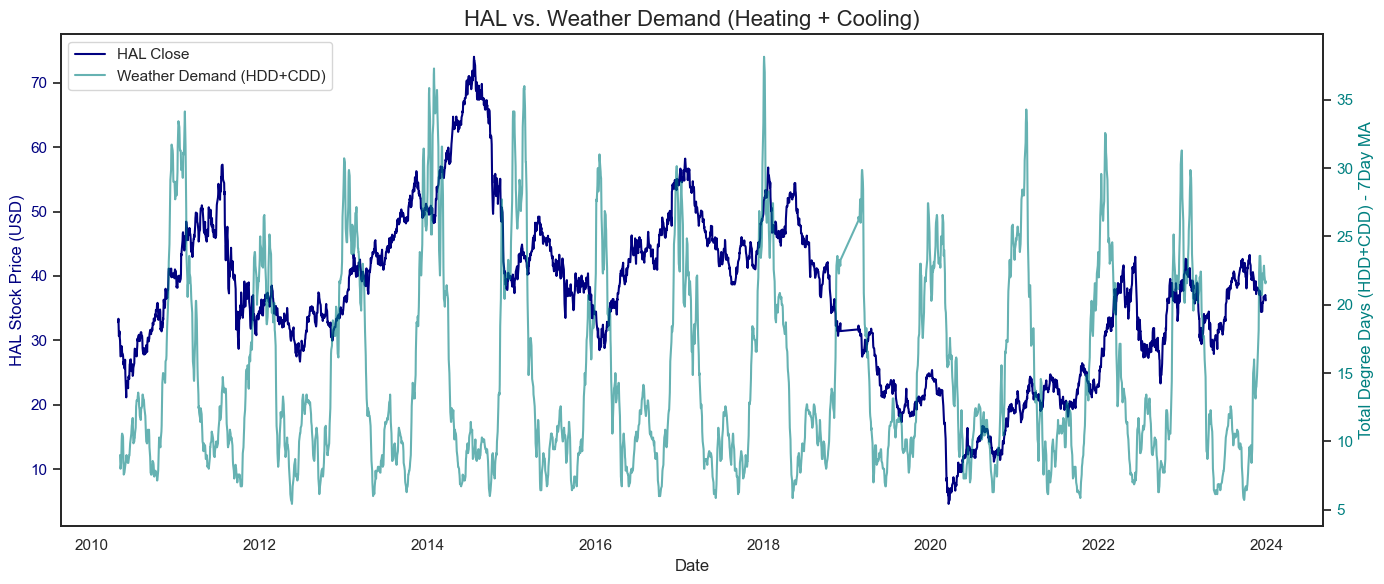

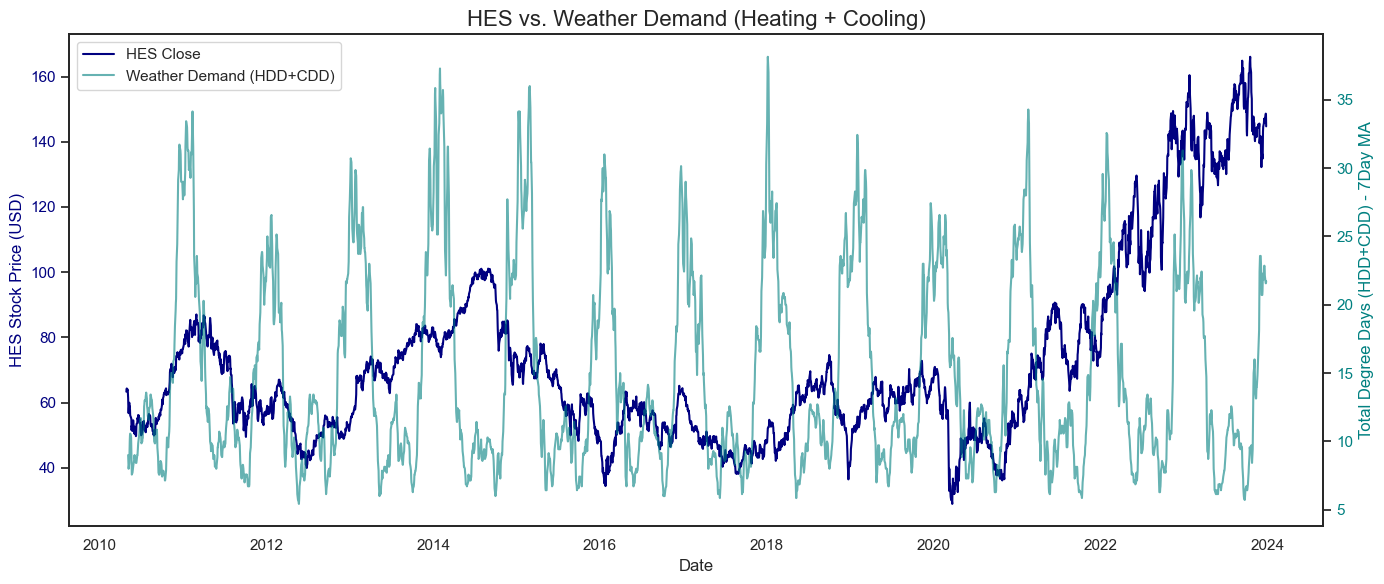

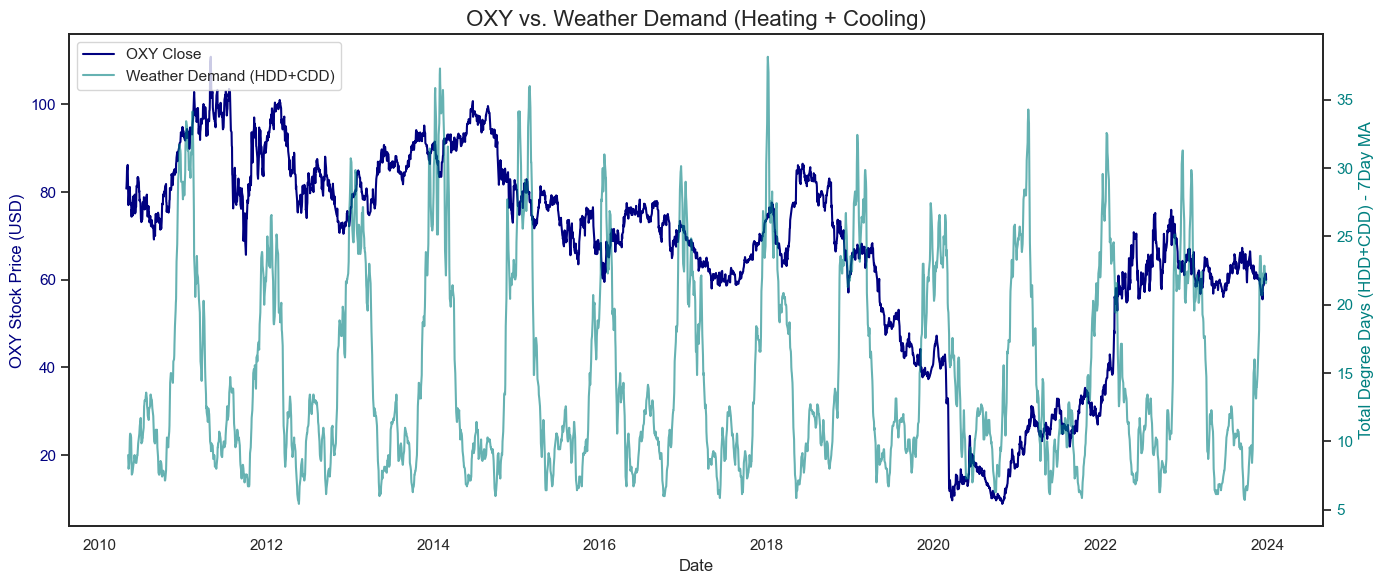

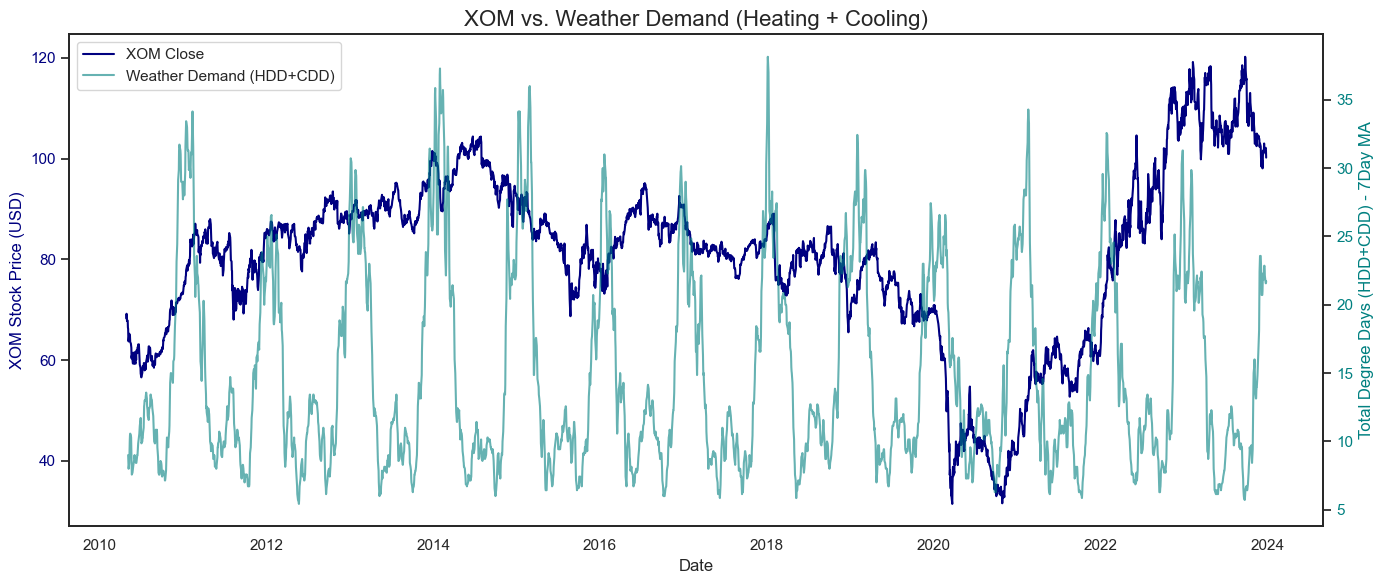

In [18]:
# Temporary merge for plotting
plot_df = pd.merge(df_skeleton, df_weather_clean, on='date', how='left')

tickers = plot_df['ticker'].unique()
sns.set(style="white")

for t in tickers:
    subset = plot_df[plot_df['ticker'] == t]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Stock Price (Left Axis)
    color1 = 'navy'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{t} Stock Price (USD)', color=color1, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color1, label=f'{t} Close', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 2. Total Weather Demand (Right Axis)
    ax2 = ax1.twinx()  
    color2 = 'teal' # Teal represents "Atmosphere/Weather"
    ax2.set_ylabel('Total Degree Days (HDD+CDD) - 7Day MA', color=color2, fontsize=12)
    ax2.plot(subset['date'], subset['Total_DD_MA7'], color=color2, label='Weather Demand (HDD+CDD)', linestyle='-', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title(f"{t} vs. Weather Demand (Heating + Cooling)", fontsize=16)
    
    # Combined Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.tight_layout()
    plt.show()